In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import xarray as xr
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, partial, tpe, Trials
import sys

sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt

random_state = 42

base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])


In [5]:
## adding intraday feature
ds['volume_0'] = ds['volume'].sum(dim='timeslot')
ds['morning_volume_ratio'] = ds['volume'].isel(timeslot=slice(2)).sum(dim='timeslot') / ds['volume_0']
ds['tail_volume_ratio'] = ds['volume'].isel(timeslot=slice(-3, -1)).sum(dim='timeslot') / ds['volume_0']
ds['daily_volume_moving_3_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=3).mean()
ds['daily_volume_moving_5_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=5).mean()
ds['close_moving_5_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=5).mean()
ds['close_moving_10_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=10).mean()
ds['close_moving_20_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=20).mean()


In [8]:
features = ['earnings', 'earnings_ttm', 'book', 'sales', 'cashflow', 'market_cap', 'volatility', 'morning_volume_ratio', 'tail_volume_ratio', 'daily_volume_moving_3_ratio', 'daily_volume_moving_5_ratio', 'close_moving_5_ratio', 'close_moving_10_ratio', 'close_moving_20_ratio']


slice(None, 2, None)

## Gradient Boosting Method

## Market Index (Baseline)

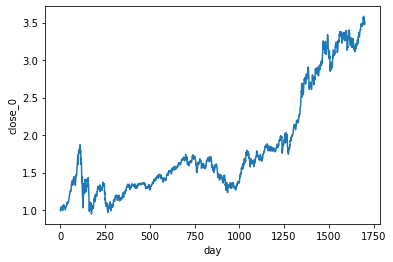

In [15]:
## passive trading; all asset
(ds['close_0'] / ds['close_0'].isel(day=0)).mean(dim='asset').plot(x='day')

## Moving Average Strategy

In [10]:
class MAPortfolio:
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        ma_5 = X_.close_moving_5_ratio
        ma_20 = X_.close_moving_20_ratio
        y_sgn_1 = 10 > (ma_20 / ma_5)
        y_sgn_2 = (ma_20 / ma_5) > 1.02
        y_sgn = y_sgn_1 & y_sgn_2
        s = y_sgn.sum(dim='asset').item()
        # print(y_sgn)
        # if s < 1e-6:
        #    return y_sgn
        # return y_sgn / s
        return y_sgn / 54

In [11]:
ma_portfolio = MAPortfolio()
stat = bt.cross_validation(ma_portfolio, features, ds, lookback_window=10, need_full_lookback=True)

  0%|          | 0/1700 [00:00<?, ?it/s]

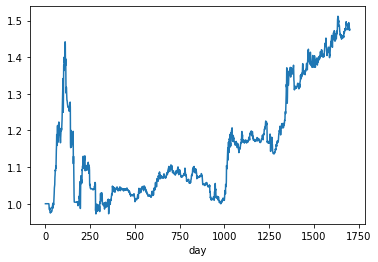

In [12]:
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.exp(np.log(simple_return + 1).cumsum())).plot(x='day')

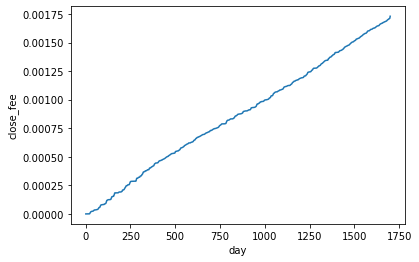

In [13]:
stat.close_fee.mean(dim='asset').cumsum(dim='day').plot(x='day')

## Value Investment (PE)

In [51]:
class PEPortfolio:
    def __init__(self):
        pass

    def initialize(self, X, y):
        pass

    def train(self, X, y):
        pass

    def construct(self, X):
        current_day = X.day.max().item()
        X_ = X.sel(day=[current_day])
        pe = X_.pe
        good_company = (pe > 0) & (pe < 15) # find companies with good pe
        market_pe = pe.median().item() # find market median pe to see if market is hyped
        investment = np.where(good_company, 1 / pe**5, 0) # invest only the good company
        s = max(1e-6, investment.sum())
        y = investment / s
        return y * min(50 / market_pe, 1) # scaled by market hypeness


In [52]:
pe_portfolio = PEPortfolio()
stat = bt.cross_validation(pe_portfolio, ['pe'], ds, lookback_window=3, need_full_lookback=True)

  0%|          | 0/1700 [00:00<?, ?it/s]

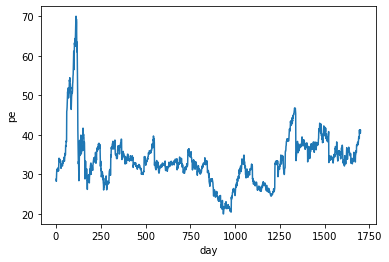

In [44]:
### Investigate market PE
pe = ds['pe'].median(dim='asset').plot(x='day')

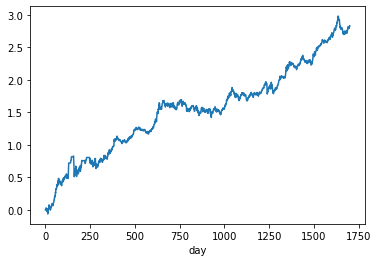

In [20]:
# 0<pe<15; market_pe = 40
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


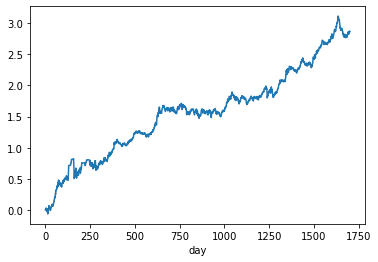

In [23]:
# 0<pe<15; market_pe = 40; inverse PE squared
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


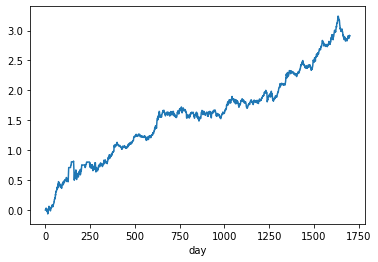

In [26]:
# 0<pe<15; market_pe = 40; inverse PE cubed
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


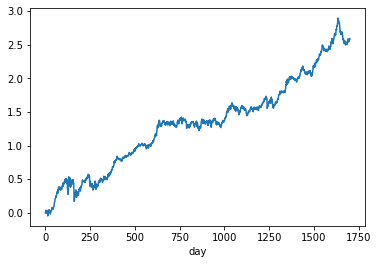

In [29]:
# 0<pe<20; market_pe = 40; inverse PE cubed
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


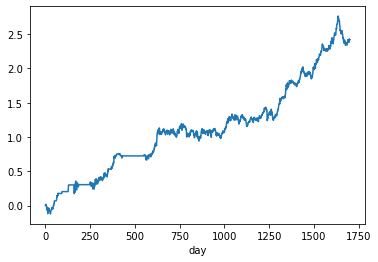

In [32]:
# 0<pe<13; market_pe = 40; inverse PE cubed
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


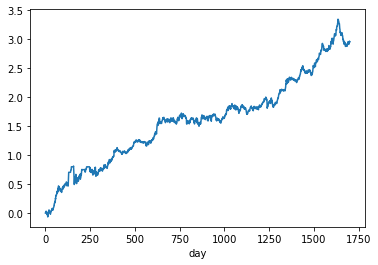

In [35]:
# 0<pe<15; market_pe = 40; inverse PE **4
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')


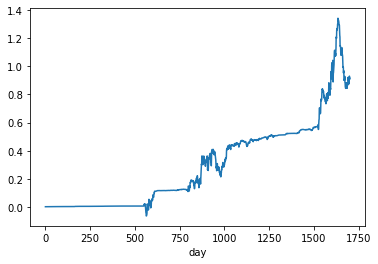

In [38]:
# 0<pe<15; market_pe = 40; inverse PE **8
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')

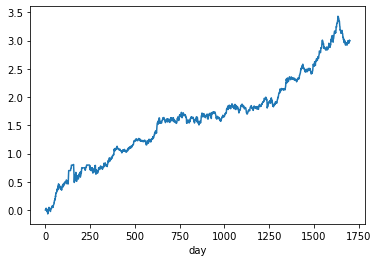

In [41]:
# 0<pe<15; market_pe = 40; inverse PE **5
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')

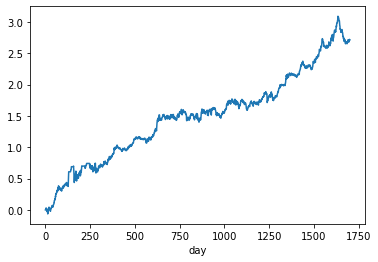

In [47]:
# 0<pe<15; market_pe = 30; inverse PE **5
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')

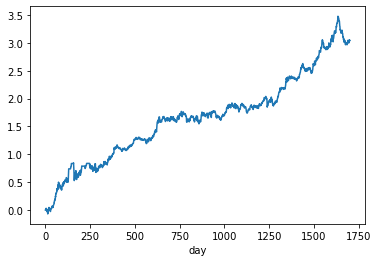

In [53]:
# 0<pe<15; market_pe = 50; inverse PE **5
simple_return = (stat.holding_return - stat.open_fee.shift(day=1) - stat.close_fee).fillna(0).sum(dim='asset')
(np.log(simple_return + 1).cumsum()).plot(x='day')